# Reconhecimento de Padrões 
## Projeto 2
- Este projeto tem como objetivo detectar e tornar uniforme frequências do tipo Alpha. O tipo Alpha é representado entre as frequências 8 e 12 Hz. Esse tipo de frequência é identificado em momentos de relaxamento e sonolência, de preferência com os olhos fechados.Na base de dados apresentada foram disponibilizados dados dos tipos 'alpha', 'beta', 'gamma', 'theta'. Também existem dados referentes á outros eletrodos que não são necessários para a verificação deste trabalho, então são retirados em um préprocessamento, assim como a delimitação por meio de filtros. 

- Primeiramente são realizadas as importações necessárias para o projeto.

In [33]:
from mne.time_frequency import psd_welch
import pandas as pand
from mne.time_frequency import psd_welch as pw
import numpy as np
import mne
import matplotlib.pyplot as plt

- Após importar as bibliotecas necessárias, são definidas algumas variáveis de forma global.

In [34]:
ch_names_1 = ['index', 'PO3', 'PO4', 'P8', 'O1', 'O2', 'P7', '7', '8', 'x', 'y', 'z', 'tempo']
ch_names_utils = ['PO3', 'PO4', 'P8', 'O1', 'O2', 'P7']
buffer_size = 4

- É definida a função de leitura do arquivo, bem como a retirada de alguns dados não necessários.

In [35]:
def read_remove_eletro(nameData):
    readed = pand.read_csv(nameData, skiprows=6, names=ch_names_1)
    readed = readed.drop(['index','7', '8', 'x', 'y', 'z', 'tempo'], axis=1)
    len_readed = len(readed)
    return len_readed, readed.transpose()

- Essa função é definida com o intuíto de agrupar as informações de cada eletrodo, com seus valores,realizar a aplicação do filtro notch, e o filtro passa-faixa com intervalo de 5-50 por 4x, afim de conseguir um melhor resultado.

In [36]:
def aux_pre_proc(data):

    ch_types = ['eeg'] * 6

    info = mne.create_info(ch_names=ch_names_utils, sfreq=256, ch_types=ch_types)
    raw = mne.io.RawArray(data, info, verbose= False)
    mont = mne.channels.read_montage('standard_1020')
    raw.set_montage(mont)

    raw.notch_filter(np.arange(60,121,60), fir_design='firwin')

    raw.filter(5,50)
    raw.filter(5,50)
    raw.filter(5,50)
    raw.filter(5,50)

    return raw

- Função com a responsabilidade de plotar o gráfico no momento em que a frequência do tipo Alpha está consideravelmente maior que as demais frequências.

In [37]:
def plot_graphics_frequency(avg_freq):
    
    freq = avg_freq
    y = freq.keys()
    x = freq.values()
    
    plt.bar(y, x)
    
    plt.pause(1.00)
    plt.clf()

- Essa função é criada com a finalidade de distribuir melhor as operações realizadas, ou seja, quando a frequência do tipo Alpha estiver com a maior média, essa função será a responsável por realizar a plotagem do gráfico e desenhar na tela a diferença entre a frequência alfa com a segunda maior frequência naquele momento, em uma escada de 0-100.

In [38]:
def routine(results):
    plot_graphics_frequency(results)

    results_sorted = sorted(list(results.values()), reverse=True)

    print('Média: '+str(100*(results_sorted[0] - results_sorted[1])/results['alpha']))

- Função resonsável pela execução do projeto, ela é designada a criar estruturas para armazenar os valores dos resultados para tipo de frequência e seus respectivos intervalos de frequências, previamente conhecidos.

In [39]:
def exec_thread(raw, len_readed):
    # estrutura para armazenar os valores para cada tipo de eletrodo
    results = {
        'beta': {},
        'alpha': {},
        'gamma': {},
        'theta': {}
    }
    # estrutura para armazenar os intervalos de frequencia para cada eletrodo
    interval_frenquency = {
        'beta': { 'begin': 12, 'end': 30 },
        'alpha': { 'begin': 8, 'end': 12 },
        'gamma': { 'begin': 25, 'end': 100 },
        'theta': { 'begin': 5, 'end': 7 }
    }
    for i in range(0, int(len_readed/256)):

        # deslocamento dado um buffer pre-definido a cada 1s
        psdw, freq = psd_welch(raw, fmin=5, fmax=50, tmin=i, tmax=i+buffer_size, verbose=False)
        for j in results.keys():
            results[j] = max(
                            np.mean(
                                psdw[:,interval_frenquency[j]['begin']:interval_frenquency[j]['end']],
                                axis=1
                            )
                        )
        if (max(results.values()) == results['alpha']):
            routine(results)

- Executa em ordem cada processo necessário para a execução do projeto

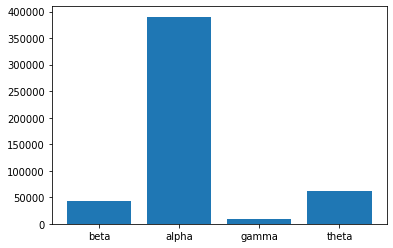

Média: 83.98156657206287


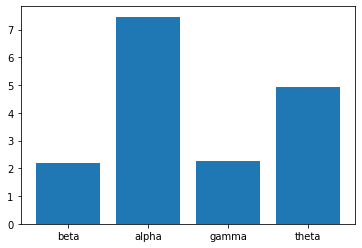

KeyboardInterrupt: 

In [41]:
if __name__ == "__main__":
    len_readed, readed = read_remove_eletro('teste.csv')
    processed = aux_pre_proc(readed)
    exec_thread(processed, len_readed)